In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# first install Pytorch
!pip3 install torch torchvision

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O
import matplotlib.pyplot as plt
import seaborn as sns

import string
import time
import os
import sys
from tqdm import tqdm
from PIL import Image

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
import torch.utils.data as data
from torch.utils.data import Dataset
import cv2

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from sklearn.metrics import f1_score

### Read data

In [ ]:
path = '/content/drive/MyDrive/T5camp/Sign_Language/'

train = pd.read_csv(path + 'sign_mnist_train.csv')
test = pd.read_csv(path + 'sign_mnist_test.csv')

In [ ]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,156,158,160,163,165,159,166,168,170,170,171,171,171,172,171,171,170,170,169,111,121,129,135,141,144,148,151,154,157,160,...,205,206,206,207,207,206,206,204,205,204,203,202,142,151,160,172,196,188,188,190,135,96,86,77,77,79,176,205,207,207,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,157,158,156,154,154,153,152,151,149,149,148,147,146,144,142,143,138,92,108,158,159,159,159,160,160,160,160,160,160,160,...,100,78,120,157,168,107,99,121,133,97,95,120,135,116,95,79,69,86,139,173,200,185,175,198,124,118,94,140,133,84,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,186,185,185,185,184,184,184,181,181,179,179,179,178,178,109,52,66,77,83,188,189,189,188,188,189,188,188,188,188,187,...,203,204,203,201,200,200,199,198,196,195,194,193,198,166,132,114,89,74,79,77,74,78,132,188,210,209,206,205,204,203,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,211,209,207,208,207,206,203,202,201,200,198,197,195,192,197,171,51,52,54,212,213,215,215,212,212,213,212,212,211,211,...,247,242,233,231,230,229,227,225,223,221,220,216,58,51,49,50,57,60,17,15,18,17,19,1,159,255,237,239,237,236,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,186,188,189,189,190,191,189,190,190,187,190,192,193,191,191,192,192,194,194,166,169,172,174,177,180,182,185,186,187,190,...,90,77,88,117,123,127,129,134,145,152,156,179,105,106,105,104,104,104,175,199,178,152,136,130,136,150,118,92,85,76,92,105,105,108,133,163,157,163,164,179


In [ ]:
train.shape

(27455, 785)

### We will handle all sign language words, except J and Z because they are gesture motions.

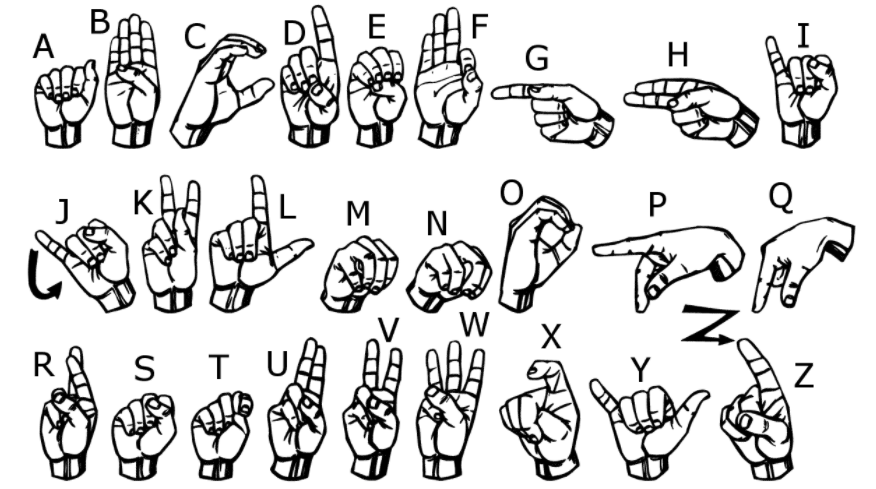

In [ ]:
from IPython.display import Image
Image("/content/drive/MyDrive/T5camp/Sign_Language/american_sign_language.PNG")

## Preprocessing

### GestureDataset class:

This class is used to process the images and labels into a format which can be directly used for training.

In [ ]:
class GestureDataset(Dataset):
    def __init__(self,data,train=True):
        self.data = data
        self.img_size=224
        self.train=train
        text="pixel"
        self.images=torch.zeros((self.data.shape[0],1))
        for i in range(1,785):
            temp_text=text+str(i)
            temp=self.data[temp_text]
            temp=torch.FloatTensor(temp).unsqueeze(1)
            self.images=torch.cat((self.images,temp),1)
        self.labels=self.data['label']
        self.images=self.images[:,1:]
        self.images=self.images.view(-1,28,28)
        
    def __getitem__(self,index):
        img=self.images[index]
        img=img.numpy()
        img=cv2.resize(img,(self.img_size,self.img_size))
        tensor_image=torch.FloatTensor(img)
        tensor_image=tensor_image.unsqueeze(0)
        tensor_image/=255.
        if self.train:
            return tensor_image,self.labels[index]
        else:
            return tensor_image
    def __len__(self):
        return self.images.shape[0]

In [ ]:
train_data = GestureDataset(train)
test_data = GestureDataset(test)

## Building a CNN model by Pytorch

We can use the Data Loader to go through the data.
- batch_size: how many samples (number of observations) per batch to load at once from the training set.
- num_workers: any positive integer allows us to use multi-processing

In [ ]:
#DataLoader combines a dataset and a sampler to provides an iterable over dataset.
train_dataloader= data.DataLoader(dataset=train_data, shuffle = True, batch_size=128, num_workers=2  )
test_dataloader= data.DataLoader(dataset=test_data, shuffle = True,batch_size=64, num_workers=2  )

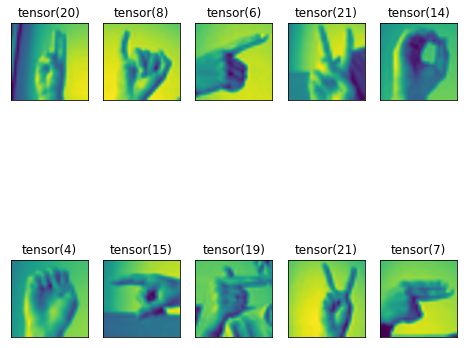

In [ ]:
#Randomly display 10 images from the train dataset by iterating train_dataloader()
%matplotlib inline
dataiter=iter(train_dataloader)
images, labels= dataiter.next()
npimg= images.numpy()
fig = plt.figure(figsize=(8, 8))
for idx in np.arange(10):
    ax=fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    ax.imshow(npimg[idx].reshape(224,224),interpolation= 'bicubic')
    ax.set_title(labels[idx])

### Defining the Model:
Defining __Net__ class for Classification.
- __init__ method:
initialize the network layers. the model contains 5 convolutional modules.
- __forward__ method:
to process the input through the initialized layers and return the final output.

In [ ]:
class Net(nn.Module):
  def __init__(self):
      super(Net, self).__init__()
      self.Conv1 = nn.Sequential(
      nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5),
      nn.MaxPool2d(kernel_size=2),
      nn.ReLU(),
      nn.BatchNorm2d(32)
      )
      self.Conv2 = nn.Sequential(
      nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),
      nn.MaxPool2d(kernel_size=2),
      nn.ReLU(),
      nn.BatchNorm2d(64)
      )
      self.Conv3 = nn.Sequential(
      nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
      nn.MaxPool2d(kernel_size=2),
      nn.ReLU(),
      nn.BatchNorm2d(128)
      )
      self.Conv4 = nn.Sequential(
      nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
      nn.MaxPool2d(kernel_size=2),
      nn.ReLU(),
      nn.BatchNorm2d(256)
      )
      self.Conv5 = nn.Sequential(
      nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3),
      nn.MaxPool2d(kernel_size=2),
      nn.ReLU(),
      nn.BatchNorm2d(512)
      )
      self.Linear1 = nn.Linear(512 * 4 * 4, 256)
      self.dropout=nn.Dropout(0.1)
      self.Linear3 = nn.Linear(256, 25)
  def forward(self, x):
        x = self.Conv1(x)
        x = self.Conv2(x)
        x = self.Conv3(x)
        x = self.Conv4(x)
        x=self.dropout(x)
        x = self.Conv5(x)
        x = x.view(x.size(0), -1)
        x = self.Linear1(x)
        x = self.dropout(x)
        x = self.Linear3(x)
        return x

In [ ]:
model = Net()
model

Net(
  (Conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [ ]:
# Validating the model against the Test dataset and generate the accuracy and loss.
def eval_model(model, criterion, test_dataloader, cuda=True):
    
    if cuda:
        model = model.cuda()
    
    model = model.eval()
    
    running_loss = 0.
    num_correct = 0.
    num_total = 0.
    
    for batch, labels in test_dataloader:
        
        if cuda:
            batch = batch.cuda()
            labels = labels.cuda()
        
        out = model(batch)
        pred_labels = out.argmax(dim=1)
        num_correct += float((pred_labels == labels).sum())
        
        loss = criterion(out, labels)
        running_loss += loss.data.cpu()
        
        num_total += labels.shape[0]
    
    mean_loss = running_loss / num_total
    accuracy = num_correct / num_total
    
    return mean_loss, accuracy

### Train the model

In [ ]:
def train_model(n_epochs, model, optimizer, criterion, train_dataloader, test_dataloader, cuda=True):
    
    if cuda:
        model = model.cuda()
    
    model = model.train()
    
    train_loss, train_acc = [], []
    test_loss, test_acc = [], []
    
    for epoch in range(n_epochs):
        t0 = time.perf_counter()
        
        running_loss = 0.
        num_correct = 0.
        num_total = 0.
        
        for batch, labels in train_dataloader:
            if cuda:
                batch = batch.cuda()
                labels = labels.cuda()
            
            optimizer.zero_grad()
            
            out = model(batch)
            pred_labels = out.argmax(dim=1)
            num_correct += float((pred_labels == labels).sum())
            num_total += labels.shape[0]
            
            
            
            loss = criterion(out, labels)
            running_loss += loss
            loss.backward()
            optimizer.step()
        
        epoch_loss = running_loss / num_total
        epoch_acc = num_correct / num_total
        
        train_loss.append(epoch_loss.data.cpu())
        train_acc.append(epoch_acc)
        
        t_loss, t_acc = eval_model(model, criterion, test_dataloader, cuda=True)
        
        test_loss.append(t_loss.data.cpu())
        test_acc.append(t_acc)
        
        t1 = time.perf_counter()
        
        delta_t = t1 - t0
        print(f"EPOCH {epoch} ({round(delta_t, 4)} s.): train loss - {epoch_loss}, train accuracy - {epoch_acc}; test loss - {t_loss}, test accuracy - {t_acc}")
        
    
    return model, train_loss, train_acc, test_loss, test_acc 

- We used Adam as optimizer with learning rate (1e-3)
- We defined the loss function to be Cross Entropy, which in Pytorch is what we use for Multi Class classification

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [ ]:
model, train_loss, train_acc, test_loss, test_acc = train_model(20, model, optimizer, criterion, train_dataloader, test_dataloader, cuda=True)

EPOCH 0 (142.6902 s.): train loss - 0.0018468783237040043, train accuracy - 0.935530868694227; test loss - 0.004222674760967493, test accuracy - 0.9510596765197992
EPOCH 1 (139.954 s.): train loss - 0.040247950702905655, train accuracy - 0.7663449280641049; test loss - 0.007259500212967396, test accuracy - 0.8824595649749024
EPOCH 2 (140.072 s.): train loss - 0.0002022789849434048, train accuracy - 0.9927517756328538; test loss - 0.009115046821534634, test accuracy - 0.8989124372559956
EPOCH 3 (139.6532 s.): train loss - 2.6540505132288672e-05, train accuracy - 0.9995629211436897; test loss - 0.008422213606536388, test accuracy - 0.8970998326826548
EPOCH 4 (140.2453 s.): train loss - 7.99845474830363e-06, train accuracy - 0.9999271535239482; test loss - 0.008667530491948128, test accuracy - 0.9078360290016732
EPOCH 5 (139.7169 s.): train loss - 3.7712861740146764e-06, train accuracy - 1.0; test loss - 0.009053396061062813, test accuracy - 0.9056051310652538
EPOCH 6 (140.1653 s.): train

Text(0.5, 1.0, 'Accuracy')

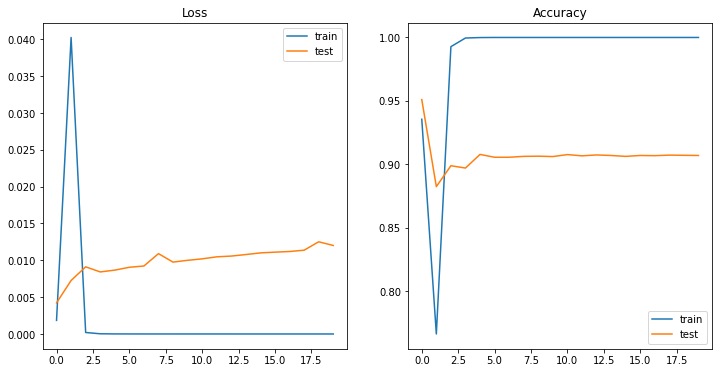

In [ ]:
# Visualization Loss and Accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
ax1.plot(train_loss)
ax1.plot(test_loss)
ax1.legend(['train', 'test'])
ax1.set_title('Loss')
ax2.plot(train_acc)
ax2.plot(test_acc)
ax2.legend(['train', 'test'])
ax2.set_title('Accuracy')

In [ ]:
# Save the model
torch.save(model.state_dict(), path + 'Pytorch_sign_language.pth')

In [ ]:
# function for just show the prediction for one image
def show_img(img, label):
    img = img.squeeze()
    img = img*40. + 159.
    imgnp = img.detach().numpy()
    plt.imshow(img, interpolation='bicubic')
    print(label)

Fact: 22, Prediction: 22
tensor(22)


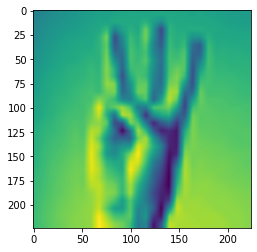

In [ ]:
testiter = iter(test_dataloader)
images, labels = next(testiter)
model = model.cpu()

idx=16
pred = model(images)
print(f'Fact: {labels[idx]}, Prediction: {(torch.argmax(pred[idx], dim=0))}')

show_img(images[idx], labels[idx])

## Transfer Learning

### ResNet18

In [ ]:
resnet18 = models.resnet18(pretrained=True)
resnet18

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
resnet18.fc = nn.Linear(in_features=512, out_features=25)

In [ ]:
resnet18_1channel = nn.Sequential(nn.Conv2d(in_channels = 1,
                    out_channels = 3,kernel_size = 3 , padding = 1), resnet18)

In [ ]:
smpl = torch.ones((10, 1, 28, 28))
resnet18_1channel(smpl).shape

torch.Size([10, 25])

In [ ]:
optimizer = optim.Adam(resnet18_1channel.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [ ]:
model, train_loss, train_acc, test_loss, test_acc = train_model(20, resnet18_1channel, optimizer, criterion, train_dataloader, test_dataloader, cuda=True)

EPOCH 0 (187.9287 s.): train loss - 0.0004856208397541195, train accuracy - 0.9845201238390093; test loss - 2.6034414986497723e-05, test accuracy - 1.0
EPOCH 1 (183.9195 s.): train loss - 7.473973795413258e-08, train accuracy - 1.0; test loss - 3.6423061828827485e-05, test accuracy - 1.0
EPOCH 2 (183.9161 s.): train loss - 7.2639783077477205e-09, train accuracy - 1.0; test loss - 1.569186133565381e-05, test accuracy - 1.0
EPOCH 3 (183.9113 s.): train loss - 3.8249576839177735e-09, train accuracy - 1.0; test loss - 1.5042915038065985e-05, test accuracy - 1.0
EPOCH 4 (183.9461 s.): train loss - 2.378371721789563e-09, train accuracy - 1.0; test loss - 1.6385434719268233e-05, test accuracy - 0.9997211377579476
EPOCH 5 (184.0653 s.): train loss - 1.633142066026494e-09, train accuracy - 1.0; test loss - 1.7163594748126343e-05, test accuracy - 0.9997211377579476
EPOCH 6 (184.2483 s.): train loss - 1.1872699490211858e-09, train accuracy - 1.0; test loss - 1.486418659624178e-05, test accuracy -

Text(0.5, 1.0, 'Accuracy')

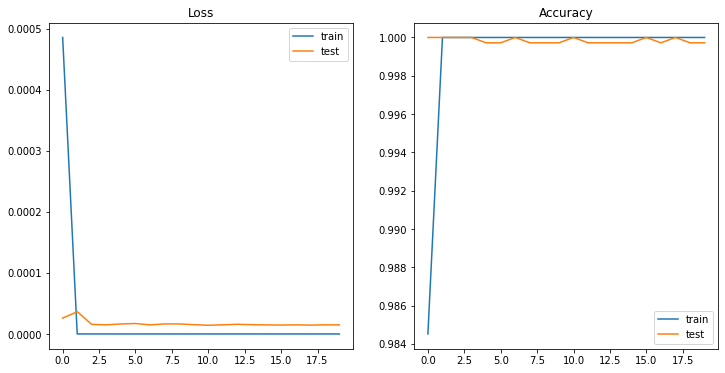

In [ ]:
# Visualization Loss and Accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
ax1.plot(train_loss)
ax1.plot(test_loss)
ax1.legend(['train', 'test'])
ax1.set_title('Loss')
ax2.plot(train_acc)
ax2.plot(test_acc)
ax2.legend(['train', 'test'])
ax2.set_title('Accuracy')

In [ ]:
# Save the model
torch.save(model.state_dict(), path + 'Resnet18_sign_language.pth')

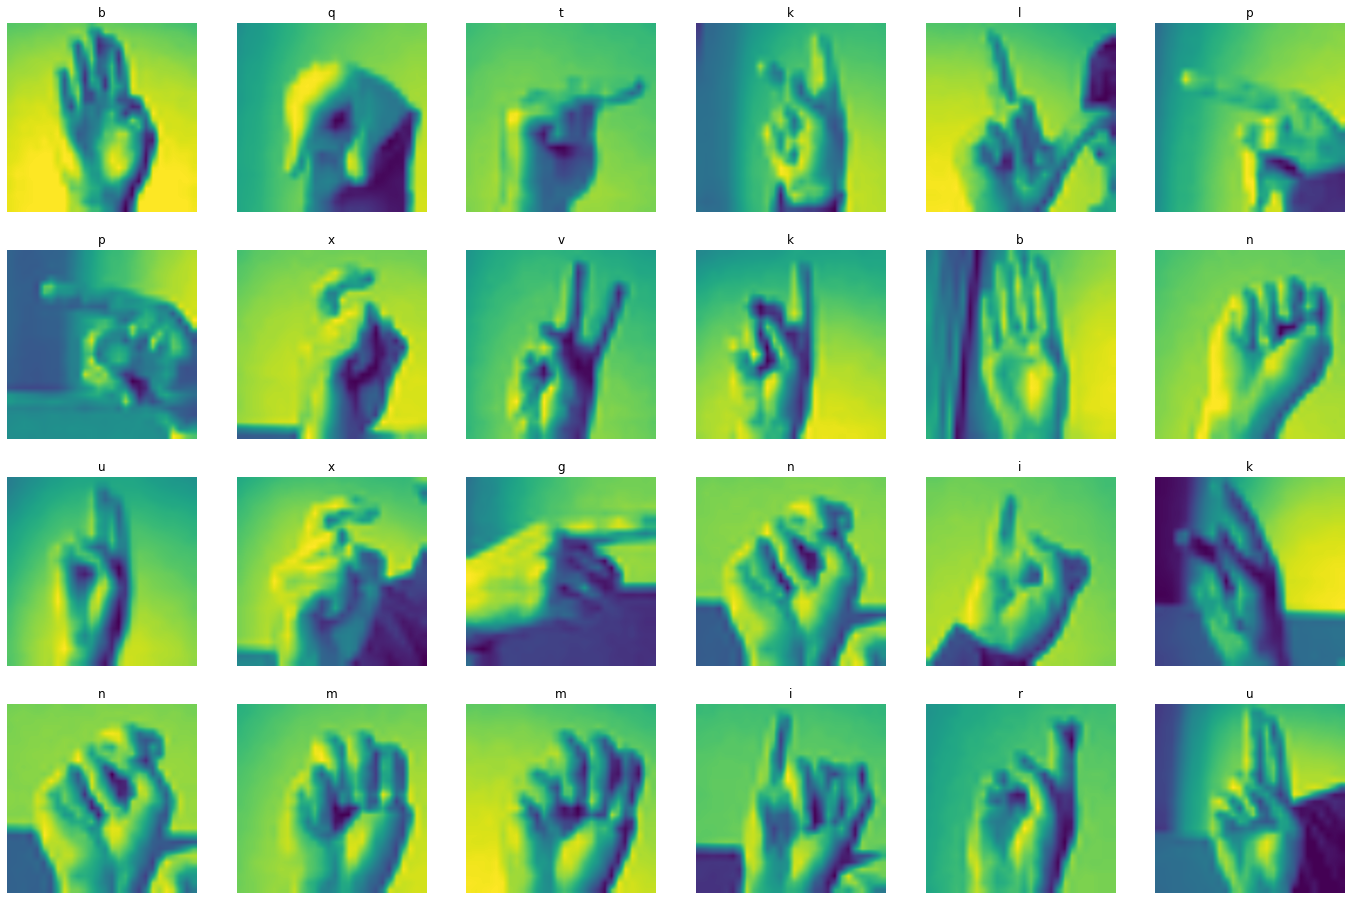

In [ ]:
# function for show the prediction randomly for 24 images
samples, _ = iter(test_dataloader).next()
samples = samples.cuda()
model = model.cuda()
fig = plt.figure(figsize=(24, 16))
fig.tight_layout()
output = model(samples[:24])
pred = torch.argmax(output, dim=1)
pred = [p.item() for p in pred]
ad = {0:'a', 1:'b', 2:'c', 3:'d', 4:'e', 5:"f", 6:'g', 7:'h', 8:'i', 10:'k', 11:'l', 12:'m', 13:'n',
      14:'o', 15:'p', 16:'q', 17:'r', 18:'s', 19:'t', 20:'u', 21:'v', 22:'w', 23:'x', 24:'y'}
for num, sample in enumerate(samples[:24]):
    plt.subplot(4,6,num+1)
    plt.title(ad[pred[num]])
    plt.axis('off')
    sample = sample.cpu().numpy()
    plt.imshow(np.reshape(sample, (224,224)))